# Notebook to retrieve imagery matching drone pass timesteps and area

In [1]:
%matplotlib inline
from datacube.helpers import write_geotiff
from datacube.storage import masking
from datacube.utils.geometry import CRS, point
from datacube import Datacube
from datetime import datetime

import dask
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import xarray as xr


# Point this to where you have the algorithms from the dea-notebooks/algorithms saved
sys.path.append(os.path.abspath('../../Scripts'))
from dea_datahandling import load_ard
from dea_plotting import rgb

# Connect to datacube
dc = Datacube(app='Sentinel2 pixelgrid')

%load_ext autoreload
%autoreload 2

In [2]:
# Create a reusable query
query = {
    #-27.521489, 153.463994 -27.556528, 153.507053
    'x': (153.39, 153.58),
    'y': (-27.38, -27.74),
    'time': ('2019-09', '2019-09-10'),
    'measurements': ['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir_1','nbart_swir_2','nbart_swir_3'],
    'output_crs': 'EPSG:3577',
    'resolution': (-10, 10),
    'group_by': 'solar_day'
}

In [3]:
# Load available data from both Sentinel 2 satellites
ds = load_ard(dc=dc,
              products=['s2a_ard_granule', 's2b_ard_granule'],
              min_gooddata=0,
              **query)

Loading s2a_ard_granule data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Loading s2b_ard_granule data
    Applying pixel quality/cloud mask
    Applying invalid data mask
    Applying contiguity mask
Combining and sorting data
    Returning 4 observations 


In [4]:
ds

<xarray.Dataset>
Dimensions:       (time: 4, x: 2504, y: 4292)
Coordinates:
  * x             (x) float64 2.073e+06 2.073e+06 ... 2.099e+06 2.099e+06
  * y             (y) float64 -3.144e+06 -3.144e+06 ... -3.187e+06 -3.187e+06
  * time          (time) datetime64[ns] 2019-09-02T00:02:41.024000 ... 2019-09-08T23:52:41.024000
Data variables:
    nbart_blue    (time, y, x) float32 457.0 457.0 469.0 ... 379.0 407.0 396.0
    nbart_green   (time, y, x) float32 389.0 404.0 403.0 ... 253.0 297.0 295.0
    nbart_red     (time, y, x) float32 108.0 114.0 101.0 ... 197.0 189.0 198.0
    nbart_nir_1   (time, y, x) float32 46.0 56.0 49.0 46.0 ... 152.0 172.0 161.0
    nbart_swir_2  (time, y, x) float32 27.0 27.0 28.0 28.0 ... 106.0 106.0 106.0
    nbart_swir_3  (time, y, x) float32 22.0 22.0 18.0 18.0 ... 95.0 94.0 94.0
Attributes:
    crs:      EPSG:3577

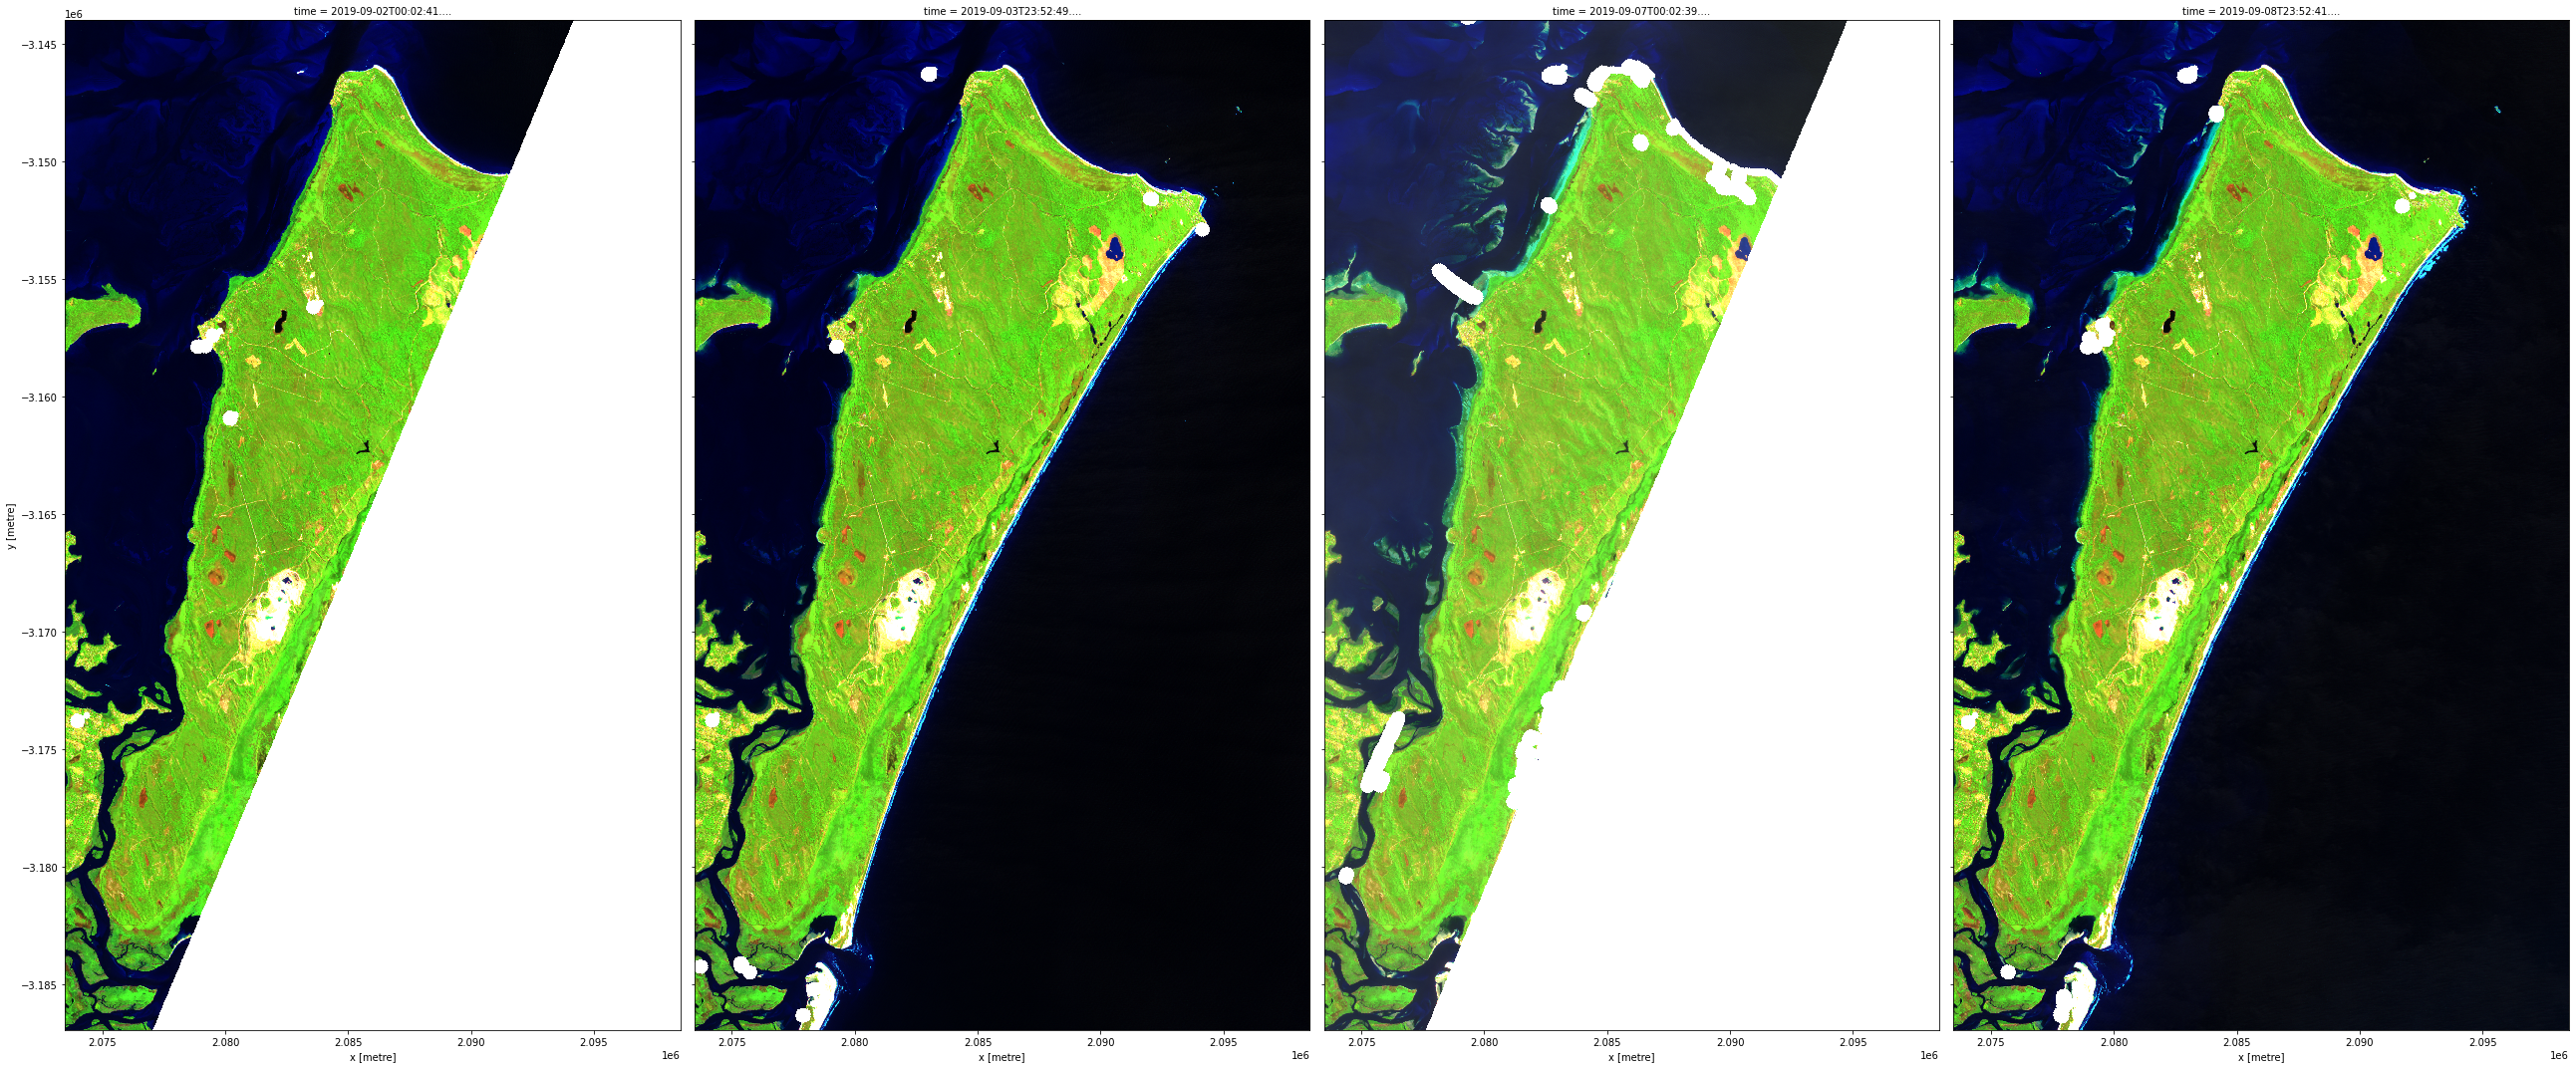

In [5]:
rgb(ds, bands = ['nbart_swir_2','nbart_nir_1','nbart_green'],size =15, col='time')

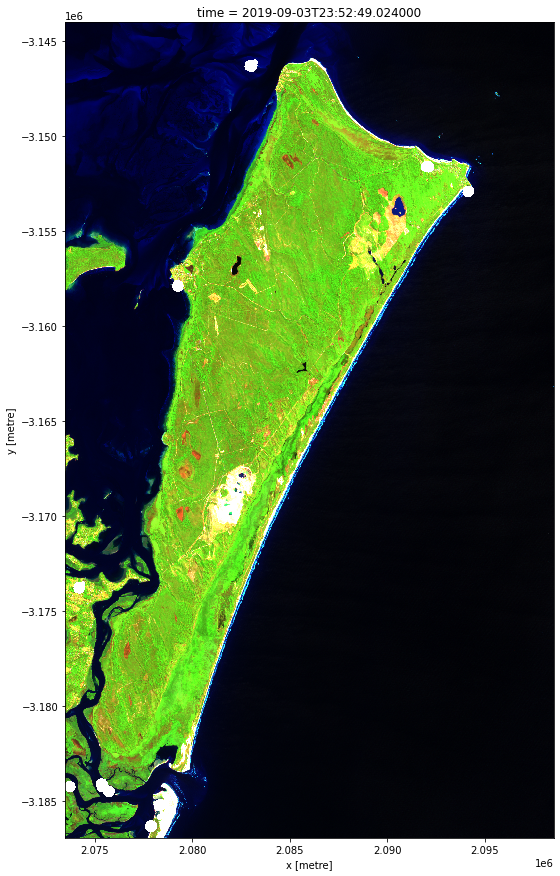

In [6]:
rgb(ds, bands = ['nbart_swir_2','nbart_nir_1','nbart_green'], index=1,size=15)

In [7]:
rgb_tiff = ds.isel(time=1)

In [8]:
write_geotiff('/g/data/r78/rjd547/ARI/imagery_matching/2019-09-04-S2.tif', rgb_tiff)

RasterioIOError: Attempt to create new tiff file '/g/data/r78/rjd547/ARI/imagery_matching/2019-09-04-S2.tif' failed: No such file or directory

## Load landsat data for the same period

In [ ]:
# Create a reusable query
query2 = {
    'x': (153.39, 153.58),
    'y': (-27.38, -27.74),
    'time': ('2019-08-01', '2019-10-01'),
    'measurements': ['nbart_blue', 'nbart_green','nbart_red', 'nbart_nir','nbart_swir_1','nbart_swir_2'],
    'output_crs': 'EPSG:3577',
    'resolution': (-30, 30),
    'group_by': 'solar_day'
}

In [ ]:
dc2 = Datacube(app='Ls8 pixelgrid', env='c3-samples')

In [ ]:
# Load available data from Landsat satellites
ds2 = load_ard(dc=dc2,
              products=['ga_ls8c_ard_3'],
              **query2)

In [ ]:
ds2

In [ ]:
rgb(ds, bands = ['nbart_swir_2','nbart_nir','nbart_green'],size =15, col='time')

In [ ]:
rgb(ds2, bands = ['nbart_swir_2','nbart_nir','nbart_green'], index=1,size=15)

In [ ]:
#dc2.list_measurements()

In [ ]:
import numpy as np
import geopandas as gpd
import rasterio.features
from shapely.geometry import shape
# Input array to segment and vectorise
input_array = np.random.rand(5, 5)
input_transform = (30, 0, 0, 0, -30, 0)  # replace with xarray transform
input_crs = 'EPSG:4326'  # replace with xarray CRS
# Create array with a unique value per cell
unique_pixels = np.arange(input_array.size).reshape(input_array.shape)
# Vectorise each unique feature in array
vectors = rasterio.features.shapes(source=unique_pixels.astype(np.int16), 
                                     transform=input_transform)
# Convert the generator into a list
vectors = list(vectors)
# Extract the polygon coordinates and values from the list
polygons = [polygon for polygon, value in vectors]
values = [value for polygon, value in vectors]
# Convert polygon coordinates into polygon shapes
polygons = [shape(polygon) for polygon in polygons]
# Create a geopandas dataframe populated with the polygon shapes
gdf = gpd.GeoDataFrame(data={'id': values},
                       geometry=polygons,
                       crs=input_crs)
# Plot vectors by attribute
gdf.plot(column='id', edgecolor='black')